In [1]:

# --- Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [2]:
import kagglehub
path = kagglehub.dataset_download("nikhil1e9/loan-default")
df = pd.read_csv(f"{path}/Loan_default.csv")

print("Initial Shape:", df.shape)
df.head()

Initial Shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
# Drop duplicate and ID column
df = df.drop_duplicates()
if 'LoanID' in df.columns:
    df = df.drop('LoanID', axis=1)
print("After Cleaning:", df.shape)

After Cleaning: (255347, 17)


In [4]:
# Check missing values
print("\nMissing Values:\n", df.isnull().sum().sum())


Missing Values:
 0


In [5]:
cat_cols = ['Education','EmploymentType','MaritalStatus','HasMortgage',
            'HasDependents','LoanPurpose','HasCoSigner']

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

target = 'Default'
X = df.drop(columns=[target])
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Defaulters in training: {(y_train.mean()*100):.2f}%")

Train size: (204277, 16), Test size: (51070, 16)
Defaulters in training: 11.61%


In [7]:
num_cols = ['Age','Income','LoanAmount','CreditScore','MonthsEmployed',
            'NumCreditLines','InterestRate','LoanTerm','DTIRatio']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [8]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Class Ratio (pos/neg): {scale_pos_weight:.2f}")

Class Ratio (pos/neg): 7.61


In [9]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name} Results:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    return [acc, prec, rec, f1]


results = {}

In [10]:
# --- Logistic Regression ---
log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', solver='saga')
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
results['Logistic Regression'] = evaluate_model("Logistic Regression", y_test, y_pred_log)


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     45139
           1       0.22      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.67      0.73     51070

Confusion Matrix:
 [[30251 14888]
 [ 1761  4170]]


In [11]:
# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=12, class_weight='balanced_subsample')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = evaluate_model("Random Forest", y_test, y_pred_rf)


Random Forest Results:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     45139
           1       0.27      0.54      0.36      5931

    accuracy                           0.78     51070
   macro avg       0.60      0.67      0.61     51070
weighted avg       0.85      0.78      0.81     51070

Confusion Matrix:
 [[36483  8656]
 [ 2727  3204]]


In [12]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)
results['Naive Bayes'] = evaluate_model("Naive Bayes", y_test, y_pred_nb)


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.64      0.02      0.03      5931

    accuracy                           0.88     51070
   macro avg       0.76      0.51      0.48     51070
weighted avg       0.86      0.88      0.83     51070

Confusion Matrix:
 [[45089    50]
 [ 5842    89]]


In [13]:
# --- XGBoost ---
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = evaluate_model("XGBoost", y_test, y_pred_xgb)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     45139
           1       0.23      0.66      0.34      5931

    accuracy                           0.71     51070
   macro avg       0.59      0.69      0.58     51070
weighted avg       0.86      0.71      0.76     51070

Confusion Matrix:
 [[32177 12962]
 [ 2019  3912]]


In [14]:
df_results = pd.DataFrame(results).T
df_results.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
df_results = (df_results * 100).round(2)
print("\n Model Comparison (%):")
display(df_results)


 Model Comparison (%):


,Accuracy,Precision,Recall,F1
Logistic Regression,67.40,21.88,70.31,33.37
Random Forest,77.71,27.02,54.02,36.02
Naive Bayes,88.46,64.03,1.50,2.93
XGBoost,70.67,23.18,65.96,34.31


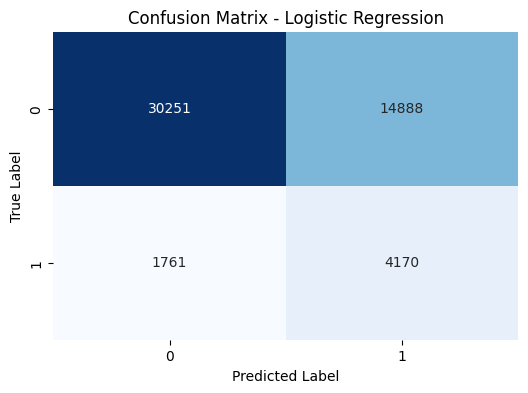

In [16]:
# Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

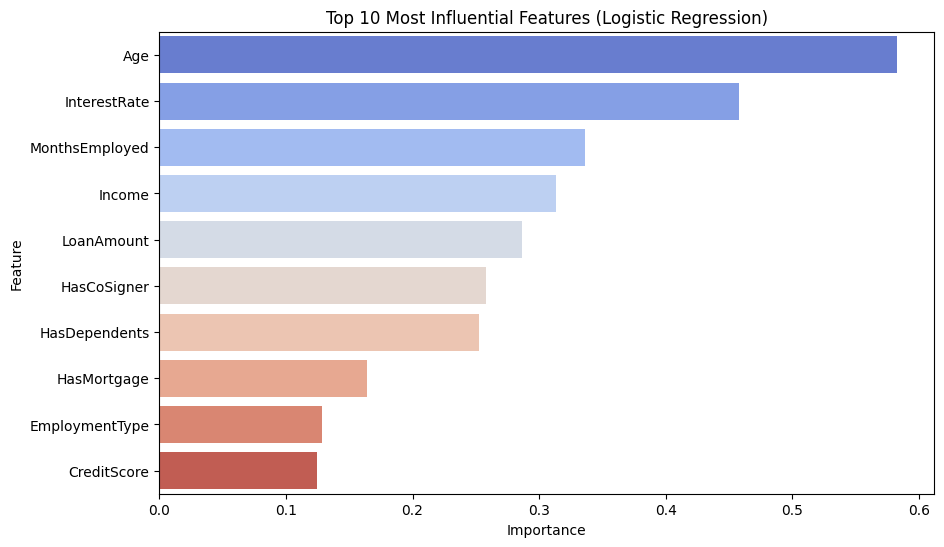

In [17]:
# Get feature importance from Logistic Regression
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(log_model.coef_[0])
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='coolwarm')
plt.title('Top 10 Most Influential Features (Logistic Regression)')
plt.show()